# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils_hr as meu
import nltk

np.set_printoptions(precision=2, linewidth=80)

C:\Users\yhutter\AppData\Local\Temp\ipykernel_27220\483943083.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\yhutter\GitRepos\fhgr-ta\code\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\yhutter\GitRepos\fhgr-ta\code\venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node inste

# Load and normalize data

In [2]:
%%time
dataset = pd.read_csv('./movie_reviews.zip', compression='zip')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# normalize datasets
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')

norm_train_reviews = tn.normalize_corpus(train_reviews, stopwords=stop_words)
norm_test_reviews = tn.normalize_corpus(test_reviews, stopwords=stop_words)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


C:\Users\yhutter\GitRepos\fhgr-ta\code\text_normalizer.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


KeyboardInterrupt: 

# Traditional Supervised Machine Learning Models

## Feature Engineering

(dauert etwas)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_reviews)
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

In [4]:
# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)

In [5]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (35000, 2091982)  Test features shape: (15000, 2091982)
TFIDF model:> Train features shape: (35000, 2091982)  Test features shape: (15000, 2091982)


## Model Training, Prediction and Performance Evaluation

In [6]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100)

In [7]:
# Logistic Regression model on BOW features
lr_bow_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['positive', 'negative'])

C:\Users\roelkeheiko\PycharmProjects\ta_2023\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance metrics:
------------------------------
Accuracy: 0.9053
Precision: 0.9053
Recall: 0.9053
F1 Score: 0.9053

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.90      0.91      0.91      7510
    negative       0.91      0.90      0.90      7490

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6768      722
        negative        699     6811


In [8]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8938
Precision: 0.8939
Recall: 0.8938
F1 Score: 0.8938

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.89      0.90      0.89      7510
    negative       0.90      0.89      0.89      7490

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6649      841
        negative        752     6758


## Klassifizierung mittels SVM

### zuerst BoW

In [9]:
svm_bow_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8988
Precision: 0.8991
Recall: 0.8988
F1 Score: 0.8988

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.91      0.89      0.90      7510
    negative       0.89      0.91      0.90      7490

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6827      663
        negative        855     6655


### dann auch hier TF-IDF 

In [10]:
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8961
Precision: 0.8964
Recall: 0.8961
F1 Score: 0.896

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.88      0.91      0.90      7510
    negative       0.91      0.88      0.89      7490

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6601      889
        negative        670     6840


# Newer Supervised Deep Learning Models

In [11]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization

## Prediction class label encoding

In [12]:
le = LabelEncoder()
num_classes=2 
# tokenize train reviews & encode train labels
tokenized_train = [tn.tokenizer.tokenize(text)
                   for text in norm_train_reviews]
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)
# tokenize test reviews & encode test labels
tokenized_test = [tn.tokenizer.tokenize(text)
                   for text in norm_test_reviews]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [13]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'positive' 'negative'] 
Encoded Labels: [0 1 0] 
One hot encoded Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


## Feature Engineering with word embeddings

In [14]:
%%time
# build word2vec model
w2v_num_features = 512
w2v_model = gensim.models.Word2Vec(tokenized_train, vector_size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3, workers=8)    

CPU times: total: 15min 43s
Wall time: 2min 18s


In [17]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [18]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

zusätzlich GloVe Modell hinzunehmen: vortrainierte Vektoren

In [19]:
# feature engineering with GloVe model
#  mit Rückgriff auf spaCy (aus dem Text Normalizer)
train_nlp = [tn.nlp(item) for item in norm_train_reviews]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [tn.nlp(item) for item in norm_test_reviews]
test_glove_features = np.array([item.vector for item in test_nlp])

In [20]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (35000, 512)  Test features shape: (15000, 512)
GloVe model:> Train features shape: (35000, 96)  Test features shape: (15000, 96)


## Modeling with deep neural networks 

### Building Deep neural network architecture

In [21]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [22]:
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)

### Visualize sample deep architecture

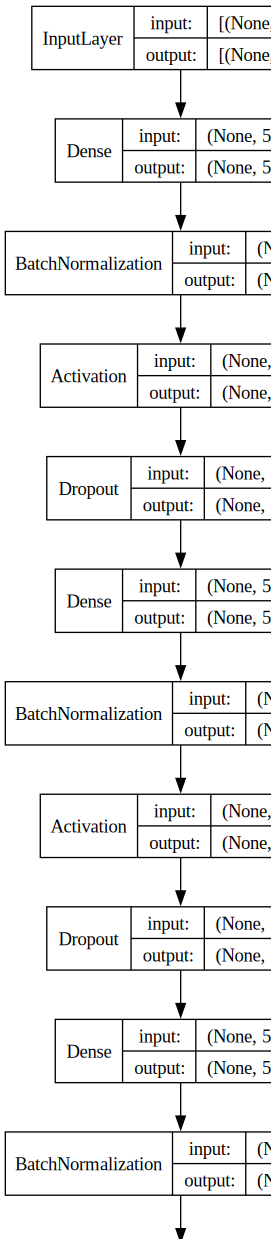

In [38]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog=r'C:\Program Files\Graphviz\bin\dot.exe', format='svg'))

### Model Training, Prediction and Performance Evaluation

In [25]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
315/315 [==============================] - 60s 179ms/step - loss: 0.3362 - accuracy: 0.8599 - val_loss: 0.3143 - val_accuracy: 0.8669
Epoch 2/10
315/315 [==============================] - 58s 186ms/step - loss: 0.2873 - accuracy: 0.8811 - val_loss: 0.3089 - val_accuracy: 0.8686
Epoch 3/10
315/315 [==============================] - 65s 207ms/step - loss: 0.2771 - accuracy: 0.8837 - val_loss: 0.2969 - val_accuracy: 0.8717
Epoch 4/10
315/315 [==============================] - 62s 195ms/step - loss: 0.2716 - accuracy: 0.8868 - val_loss: 0.2927 - val_accuracy: 0.8763
Epoch 5/10
315/315 [==============================] - 59s 188ms/step - loss: 0.2672 - accuracy: 0.8868 - val_loss: 0.2944 - val_accuracy: 0.8749
Epoch 6/10
315/315 [==============================] - 57s 182ms/step - loss: 0.2627 - accuracy: 0.8908 - val_loss: 0.3004 - val_accuracy: 0.8726
Epoch 7/10
315/315 [==============================] - 58s 184ms/step - loss: 0.2536 - accuracy: 0.8953 - val_loss: 0.2981 - val_ac

In [28]:
y_pred = np.argmax(w2v_dnn.predict(avg_wv_test_features), axis=1)
predictions = le.inverse_transform(y_pred) 

469/469 [==============================] - 14s 29ms/step


In [29]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8812
Precision: 0.8819
Recall: 0.8812
F1 Score: 0.8811

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.87      0.90      0.88      7510
    negative       0.90      0.86      0.88      7490

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6437     1053
        negative        729     6781


In [32]:
glove_dnn = construct_deepnn_architecture(num_input_features=96)  # angepasst an spaCy Sprachmodell (Vektorlänge)

In [33]:
batch_size = 100
glove_dnn.fit(train_glove_features, y_train, epochs=10, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
315/315 [==============================] - 60s 183ms/step - loss: 0.6871 - accuracy: 0.6218 - val_loss: 0.6444 - val_accuracy: 0.6294
Epoch 2/10
315/315 [==============================] - 51s 162ms/step - loss: 0.6194 - accuracy: 0.6603 - val_loss: 0.6703 - val_accuracy: 0.6171
Epoch 3/10
315/315 [==============================] - 50s 159ms/step - loss: 0.6026 - accuracy: 0.6759 - val_loss: 0.6089 - val_accuracy: 0.6691
Epoch 4/10
315/315 [==============================] - 54s 172ms/step - loss: 0.5950 - accuracy: 0.6810 - val_loss: 0.6204 - val_accuracy: 0.6666
Epoch 5/10
315/315 [==============================] - 53s 168ms/step - loss: 0.5877 - accuracy: 0.6857 - val_loss: 0.6224 - val_accuracy: 0.6543
Epoch 6/10
315/315 [==============================] - 51s 162ms/step - loss: 0.5832 - accuracy: 0.6905 - val_loss: 0.6181 - val_accuracy: 0.6546
Epoch 7/10
315/315 [==============================] - 51s 162ms/step - loss: 0.5772 - accuracy: 0.6963 - val_loss: 0.6051 - val_ac

In [35]:
y_pred = np.argmax(glove_dnn.predict(test_glove_features), axis=1)
predictions = le.inverse_transform(y_pred) 

469/469 [==============================] - 11s 24ms/step


In [36]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.6579
Precision: 0.6779
Recall: 0.6579
F1 Score: 0.6479

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.62      0.83      0.71      7510
    negative       0.74      0.49      0.59      7490

    accuracy                           0.66     15000
   macro avg       0.68      0.66      0.65     15000
weighted avg       0.68      0.66      0.65     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       3663     3827
        negative       1304     6206


schlechtere Werte, wohl auch durch die kleineren Wortvektoren

kann sicherlich mit mehr Rechenaufwand und einem umfangreicheren Sprachmodell verbessert werden